# Salary prediciton based on job description

Welcome to the second part of my analysis for a dataset on job postings for data related jobs in Vietnam market

[Link to the first notebook](https://colab.research.google.com/drive/1JblYhdVO5mUeDo_sB9-L0pyxea4ypb4)

[Link to the dataset](https://www.kaggle.com/datasets/phuocnguyen90/data-jobs-in-vietnam)

Quick links

[EDA](#EDA)

[Feature select, feature engineer](#FSFE)

  [XGBoost regression](#XGB)

  [Random forrest assemble](#RF)

  [Data engineer job testing](#DE)

  [Multivariate polynomial regression](#poly)

[Conclusion](#Conclusion)


In [1]:
# First, let's import some toolkits for the analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#!python -m spacy download en_core_web_md
#!pip install xgboost

**<a name = "EDA">Load the data, EDA</a>**

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
import spacy
nlp = spacy.load('en_core_web_md')

In [3]:
df = pd.read_csv('..\dataset\data_job_new_with_predicted_cat.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3631 entries, 0 to 3630
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          3631 non-null   int64  
 1   Company                     3631 non-null   object 
 2   Job_Title                   3631 non-null   object 
 3   YOE                         2974 non-null   float64
 4   Location                    3621 non-null   object 
 5   Est_Salary                  3377 non-null   float64
 6   Job_Description             3631 non-null   object 
 7   Link                        3631 non-null   object 
 8   Min_level                   3631 non-null   int64  
 9   Max_level                   3631 non-null   int64  
 10  VN                          3631 non-null   int64  
 11  Overseas                    3631 non-null   int64  
 12  Remote                      3631 non-null   int64  
 13  Data_Engineer_prob          3631 

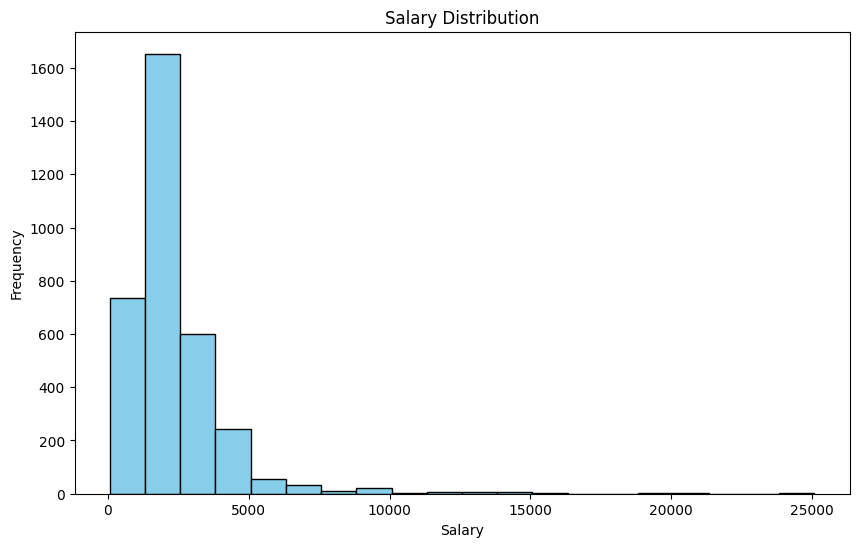

In [4]:
# Plot a histogram of salary values
plt.figure(figsize=(10, 6))
plt.hist(df['Est_Salary'], bins=20, color='skyblue', edgecolor='black')
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

In [5]:
# As we can see, the estimated salary data is rather skewed with a lot of outlier data, particularly for overseas jobs posted in Vietnam boards.
# Since the amount of data available for overseas market is rather small, it would be insufficient to create a seperate model for this analysis
# We should aim to more realistic expectations for Vietnam market, an impute the maximum salary 
df['Est_Salary'].astype(float) 
df['Est_Salary'] = df['Est_Salary'].apply(lambda x: 8000 if x >= 8000 else x)
df = df.dropna(subset=['Est_Salary'])

In [6]:
df['Est_Salary'].mean()

2349.902872371928

In [7]:
col_to_drop = ['Job_Title','ID', 'Company', 'Link', 'Data_Engineer_prob','Data_Analyst_prob', 'Data_Scientist_prob','Business_Analyst_prob','Business_Intelligence_prob','Others_prob']
clean_df=df.drop(columns=col_to_drop)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3377 entries, 0 to 3376
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   YOE                    2787 non-null   float64
 1   Location               3370 non-null   object 
 2   Est_Salary             3377 non-null   float64
 3   Job_Description        3377 non-null   object 
 4   Min_level              3377 non-null   int64  
 5   Max_level              3377 non-null   int64  
 6   VN                     3377 non-null   int64  
 7   Overseas               3377 non-null   int64  
 8   Remote                 3377 non-null   int64  
 9   Data_Engineer          3377 non-null   int64  
 10  Data_Analyst           3377 non-null   int64  
 11  Data_Scientist         3377 non-null   int64  
 12  Business_Analyst       3377 non-null   int64  
 13  Business_Intelligence  3377 non-null   int64  
 14  Others                 3377 non-null   int64  
dtypes: float6

Preprocessing some missing data

In [8]:
# Fill missing values in 'Location' with 'VN'
clean_df['Location'].fillna('VN', inplace=True)

job_categories = ['Data_Engineer', 'Data_Analyst', 'Data_Scientist', 'Business_Analyst', 'Business_Intelligence','Others']

# Calculate the average YOE for each job category and round it
average_yoe_by_category = clean_df.groupby(job_categories)['YOE'].mean().round().reset_index()

# Fill in the missing 'YOE' values based on the job category
for _, row in average_yoe_by_category.iterrows():
    condition = (clean_df[job_categories] == tuple(row[job_categories])).all(axis=1)
    clean_df.loc[condition, 'YOE'] = row['YOE']






In [9]:
# Location data is not yet cleaned 
clean_df['Location'].unique()

array(['HCM', 'HN', 'Nha Trang', 'HCM, Remote*', 'Remote', 'Binh Duong',
       'Dong Nai', 'HCM*, Dong Nai', 'Da Nang', 'HCM, Remote',
       'HCM, Da Nang*, Remote*', 'VN', 'Khanh Hoa', 'An Giang', 'Can Tho',
       'Bac Ninh, HN*', 'Quy Nhon', 'Bac Ninh', 'Hai Duong', 'Quang Ngai',
       'Gia Lai', 'Long An', 'Hung Yen, Hai Duong, Ha Noi', 'Binh Dinh',
       'VN, Remote', 'HCM, Binh Duong', 'HCM, Da Nang', 'Quang Nam',
       'BR-VT', 'HCM, Long An', 'Hoa Binh', 'Philippines',
       'HCM, Binh Duong, Dong Nai', 'Binh Duong, HCM', 'Hai Phong',
       'HCM, US*', 'Binh Duong, BR-VT', 'Malaysia, HN', 'Cambodia',
       'Da Nang, Japan*', 'Philipines', 'HCM, Khanh Hoa',
       'HCM, US*, Japan*', 'HCM, Australia*',
       'HCM, Singapore*, Australia*', 'Senior', 'HCM, Can Tho',
       'HCM, Cambodia', 'HCM, Da Nang, Remote', 'Thailand', 'HCM, HN',
       'Hong Kong', 'HCM, Dong Nai', 'Korea', 'Australia', 'Malaysia',
       'UK, Remote', 'Singapore',
       'VN*, HN, HCM, Da Nang, In

In [10]:
clean_df['Location'] = clean_df['Location'].str.replace(r'[^a-zA-Z0-9 ]', '')

# Replace typos and abbreviations
clean_df['Location'] = clean_df['Location'].replace({
    'HN': 'Ha Noi',
    'Philipines': 'Philippines'
})

# Replace 'None' and 'Senior' with 'Unspecified'
clean_df['Location'] = clean_df['Location'].replace({
    None: 'Unspecified',
    'Senior': 'Unspecified'
})

# Split values with multiple categories, keep only the least frequent category
def split_and_keep_least_frequent(categories):
    if pd.isna(categories):
        return 'Unspecified'
    else:
        # Split categories by comma
        category_list = [category.strip() for category in categories.split(',')]
        
        # Remove parenthesized content
        category_list = [category.split('(')[0].strip() for category in category_list]
        
        # Count occurrences of each category
        category_counts = pd.Series(category_list).value_counts()
        
        # Find the least frequent category
        least_frequent_category = category_counts.idxmin()
        
        return least_frequent_category

# Apply the function to the 'Location' column
clean_df['Location'] = clean_df['Location'].apply(split_and_keep_least_frequent)

clean_df['Location'] = clean_df['Location'].astype('category')
clean_df['Location'].dropna()

# Display the cleaned unique values
print(clean_df['Location'].unique())

['HCM', 'Ha Noi', 'Nha Trang', 'Remote', 'Binh Duong', ..., 'Singapore', 'VN*', 'EU', 'Japan', 'Finland']
Length: 38
Categories (38, object): ['An Giang', 'Australia', 'BR-VT', 'Bac Ninh', ..., 'UK', 'Unspecified', 'VN', 'VN*']


In [11]:
clean_df.head(5)


,YOE,Location,Est_Salary,Job_Description,Min_level,Max_level,VN,Overseas,Remote,Data_Engineer,Data_Analyst,Data_Scientist,Business_Analyst,Business_Intelligence,Others
0,3.0,HCM,65.0,Minimum 10 hours/week; Students complete at le...,0,0,1,0,0,0,0,0,0,0,1
1,3.0,HCM,85.0,"Familiar with Object-Oriented Programming, Mod...",0,0,1,0,0,0,0,0,0,0,1
2,3.0,Ha Noi,85.0,"3rd, 4th, 5th year students or have graduated ...",0,0,1,0,0,0,0,0,0,0,1
3,3.0,HCM,85.0,The program will not be suitable for you who a...,0,0,1,0,0,0,0,0,0,0,1
4,3.0,HCM,105.0,DataGenius company is recruiting Data Engineer...,0,0,1,0,0,1,1,0,0,0,0


The process of analyzing skill keywords were addressed quite carefully in the previous notebook. For the sake of simplicity, I have extracted all keywords from the previous notebook into a list

In [12]:
skills=['A/B Testing', 'Adaptability', 'Agile Methodologies', 'AI Ethics', 'AI Explainability', 'AI Fairness',
        'API Integration', 'Attention to Detail', 'Big Data', 'Business Acumen', 'Business Analysis',
        'Business Intelligence', 'Change Management', 'Classification', 'Client Management', 'Cloud Computing',
        'Clustering', 'Collaboration', 'Communication', 'Conflict Resolution', 'Containers', 'Creative Problem-Solving',
        'Creative Thinking', 'Critical Thinking', 'Dashboard Creation', 'Dashboard', 'Data Analysis',
        'Data Analytics', 'Data Architecture', 'Data Auditing', 'Data Augmentation', 'Data Catalog', 'Data Cleaning',
        'Data Cleansing', 'Data Collection', 'Data Driven', 'Data Engineering', 'Data Ethics', 'Data Exploration',
        'Data Governance', 'Data Imputation', 'Data Integration', 'Data Interpretation', 'Data Lake',
        'Data Lake Management', 'Data Lineage', 'Data Management', 'Data Manipulation', 'Data Migration', 'Data Mining',
        'Data Modeling', 'Data Monetization', 'Data Normalization', 'Data Pipelines', 'Data Preprocessing', 'Data Privacy',
        'Data Profiling', 'Data Quality', 'Data Reporting', 'Data Reshaping', 'Data Science',
        'Data Scrubbing', 'Data Security', 'Data Stewardship', 'Data Storytelling', 'Data Strategy', 'Data Testing',
        'Data Transformation', 'Data Validation', 'Data Visualization', 'Data Warehousing',
        'Data Wrangling', 'Database Design', 'Database Management', 'Data-Driven',
        'Decision-Making', 'Deep Learning', 'Dimensionality Reduction', 'Distributed Computing', 'Django', 'Docker',
        'Domain Knowledge', 'EDA', 'Ensemble', 'Ethical', 'ETL', 'Excel', 'Experimental Design',
        'FastAPI', 'Feature Engineering', 'Feature Scaling', 'Feature Selection', 'flask', 'Frameworks', 'GDPR',
        'Geospatial Analysis', 'Git', 'Gradient Boosting', 'Hadoop', 'Hypothesis Testing', 'Informatica', 'Interpersonal Skills',
        'Kanban', 'Leadership', 'Libraries', 'Machine Learning', 'Mathematics', 'Matplotlib', 'ML', 'Model Deployment',
        'Model Interpretation', 'Natural Language Processing ', 'NLP', 'nltk', 'NoSQL', 'Numpy', 'Pandas', 'Power BI',
        'Predictive Modeling', 'Presentation', 'Privacy compliance', 'Problem Definition', 'Problem Solving',
        'Project Management', 'Project Planning', 'Python', 'PyTorch', 'Quantitative Analysis', 'Query Optimization',
        'R', 'Random Forest', 'Regression Analysis', 'Reinforcement Learning', 'Requirements Gathering',
        'Sampling Techniques', 'Scikit-learn', 'Scrum', 'spacy', 'Spark', 'SQL', 'Stakeholder Management', 'Statistical Analysis',
        'Statistical Testing', 'Statistical Thinking', 'Strategic Thinking', 'Supervised Learning', 'Tableau', 'Teamwork',
        'TensorFlow', 'Text Processing', 'Time Management', 'Time Series',
        'Unsupervised Learning','vba', 'Version Control ', 'Web Scraping', 'Seaborn', 'XGBoost',
]

The aim of this task is to figure out the relationships between the job description with the estimated salary.

Next I'll develop some helper functions to extract skill keywords from a particular job description. This function will both search for exact match and semantic match via cosine similarity, based on a smaller NLP model, spaCy vectorizer

In [13]:
def phrase_tokenizer(text):

  # Tokenize the job description
  doc = nlp(text)

  # Extract noun phrases while retaining the original text
  noun_phrases = []
  for chunk in doc.noun_chunks:
      noun_phrases.append(chunk.text)

  # Tokenized words
  tokens = [token.text for token in doc]
  return tokens



In [14]:
def skills_search(job_descriptions):

  # Tokenize the job description
  doc = nlp(job_descriptions)

  # Initialize lists to store found skills
  exact_matches = []
  semantic_matches = []

  # Iterate through tokens in the job description
  for token in doc:
      for skill in skills:
          # Exact match
          if token.text.lower() == skill.lower():
              exact_matches.append(skill)
          # Semantic similarity
          elif nlp(token.text).similarity(nlp(skill)) > 0.7: #Edit the threshold here 0.7
              semantic_matches.append(skill)

  # Remove duplicates
  exact_matches = list(set(exact_matches))
  semantic_matches = list(set(semantic_matches))
  return exact_matches, semantic_matches


We'll need to save the vector table for all the keywords

In [15]:
def create_skill_encoding_table(skills, job_descriptions):
    # Create an empty DataFrame with columns for each skill
    skill_encoding_table = pd.DataFrame(columns=skills, dtype=bool)

    # Loop through job descriptions and search for skills
    for job_description in job_descriptions:
        tokens = phrase_tokenizer(job_description)

        # Create a dictionary to represent skill presence (1 if found, 0 otherwise)
        skill_presence = {skill: 1 if skill.lower() in [token.lower() for token in tokens] else 0 for skill in skills}
        # Create a DataFrame from the skill_presence dictionary
        skill_presence_df = pd.DataFrame([skill_presence])

        # Concatenate the skill_presence_df to the skill_encoding_table
        skill_encoding_table = pd.concat([skill_encoding_table, skill_presence_df], ignore_index=True)

    return skill_encoding_table






In [16]:
# Create the skill encoding table
skill_table = create_skill_encoding_table(skills, clean_df['Job_Description'])

# <a name = "FEFS">Feature engineering, feature selection </a>

In [18]:
import xgboost as xgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

#Since we'll try with different methods of feature engineering and selecting, I have created two helper functions to do the job

def feature_engineer(df, col_to_avg=None, col_to_encode=None, fill='None'):

    # Average the cols
    if col_to_avg is not None and len(col_to_avg) > 1:
        df['col_avg'] = df[col_to_avg].mean(axis=1)

    # One-hot encode the cols
    if col_to_encode is not None:
        df = pd.get_dummies(df, columns=col_to_encode, drop_first=True)

    # Fill the missing values
    if fill == 0:
        df.fillna(value=float(0), inplace=True)
    elif fill == 'NaN':
        df.fillna(value=float('NaN'), inplace=True)
    elif fill=='None':
        pass

    return df

def feature_select(df, features, skills=None):
    if skills is None:
        features = features
        target = 'Est_Salary'
    elif skills is not None:
        features = features+list(skills.columns)
        target = 'Est_Salary'
        df = df.join(skills, how='left')

    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test



In [19]:
# Let's check again what data do we have here
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3377 entries, 0 to 3376
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   YOE                    3377 non-null   float64 
 1   Location               3377 non-null   category
 2   Est_Salary             3377 non-null   float64 
 3   Job_Description        3377 non-null   object  
 4   Min_level              3377 non-null   int64   
 5   Max_level              3377 non-null   int64   
 6   VN                     3377 non-null   int64   
 7   Overseas               3377 non-null   int64   
 8   Remote                 3377 non-null   int64   
 9   Data_Engineer          3377 non-null   int64   
 10  Data_Analyst           3377 non-null   int64   
 11  Data_Scientist         3377 non-null   int64   
 12  Business_Analyst       3377 non-null   int64   
 13  Business_Intelligence  3377 non-null   int64   
 14  Others                 3377 non-null   int64 

# Base model: <a name = "XGB">XGBoost regression</a>

In [20]:
xgb_df = feature_engineer(clean_df)
xgb_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3377 entries, 0 to 3376
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   YOE                    3377 non-null   float64 
 1   Location               3377 non-null   category
 2   Est_Salary             3377 non-null   float64 
 3   Job_Description        3377 non-null   object  
 4   Min_level              3377 non-null   int64   
 5   Max_level              3377 non-null   int64   
 6   VN                     3377 non-null   int64   
 7   Overseas               3377 non-null   int64   
 8   Remote                 3377 non-null   int64   
 9   Data_Engineer          3377 non-null   int64   
 10  Data_Analyst           3377 non-null   int64   
 11  Data_Scientist         3377 non-null   int64   
 12  Business_Analyst       3377 non-null   int64   
 13  Business_Intelligence  3377 non-null   int64   
 14  Others                 3377 non-null   int64 

In [31]:
#Feature selection

# Select the relevant features

features = ['YOE', 'Min_level', 'Location','Overseas', 'VN','Remote']
categorical_columns = ['Location']

X_train, X_test, y_train, y_test = feature_select(clean_df, features, skill_table)

In [32]:
X_train

,YOE,Min_level,Location,Overseas,VN,Remote,A/B Testing,Adaptability,Agile Methodologies,AI Ethics,...,TensorFlow,Text Processing,Time Management,Time Series,Unsupervised Learning,vba,Version Control,Web Scraping,Seaborn,XGBoost
3199,3.0,2,Thailand,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
790,3.0,2,Ha Noi,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3069,3.0,2,Ha Noi,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1220,3.0,1,Ha Noi,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3085,3.0,1,HCM,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,3.0,2,Ha Noi,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1130,3.0,2,HCM,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1294,3.0,2,HCM,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,2.0,1,Ha Noi,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [28]:

# Create and train the model (Random Forest Regressor, for example)
model = xgb.XGBRegressor(objective='reg:squarederror',  enable_categorical=True, random_state=42)  
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 842.9741761529234


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Calculate R-squared (R^2)
r2 = r2_score(y_test, y_pred)
print("R-squared (R^2):", r2)


Mean Absolute Error: 699.6945606676737
Mean Squared Error: 1019074.2147106115
Root Mean Squared Error: 1009.4920577749047
R-squared (R^2): 0.46318466522961677


# Analysis

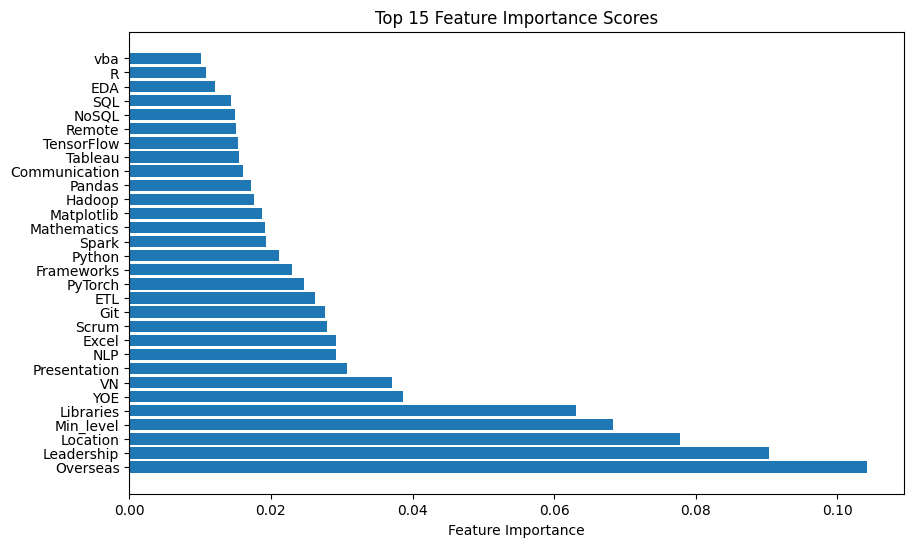

In [29]:
# Get feature importance scores
feature_importance = model.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10-15 features
top_features = feature_importance_df.head(30)  # Change 15 to the desired number of top features

# Plot feature importance for the top features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importance Scores')
plt.show()


# <a name = "RF">Random Forest Ensemble</a>

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create the random forest regressor
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_rf = RandomForestRegressor(random_state=42, **best_params)
best_rf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_rf.predict(X_test)

# Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20}

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\ensemble\_forest.py", line 348, in fit
    X, y = self._validate_data(
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\utils\validation.py", line 1146, in check_X_y
    X = check_array(
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\utils\validation.py", line 915, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\utils\_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\pandas\core\generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Ha Noi'

--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\ensemble\_forest.py", line 348, in fit
    X, y = self._validate_data(
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\utils\validation.py", line 1146, in check_X_y
    X = check_array(
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\utils\validation.py", line 915, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\sklearn\utils\_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\PC\miniconda3\envs\data_venv\lib\site-packages\pandas\core\generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Thailand'


The orignial model gave a MAE of nearly 652. Given the average salary is $2200 per month, MAE is rather high.

Using RandomForest tree assemble method, we managed to get MAE down to 623

Let's see if other models can give a better result

# <a name = "DE">Focus on Data Engineer jobs</a>

In [32]:
#create another dataset and another table skills applicable only to DE
de_df = df[df['Data_Engineer'] == 1]

de_skills = create_skill_encoding_table(skills, de_df['Job_Description'])



In [33]:
# Engineer the features
combined_de_df = feature_engineer(de_df,col_to_lbl=['Location','W_Term']) #(df, col_to_avg=None, col_to_encode=None, col_to_lbl=None, fill='NaN')

# Select the relevant features
de_features = ['YOE', 'Min_Level', 'Remote','W_Term','Location','VN']

X_de_train, X_de_test, y_de_train, y_de_test = feature_select(combined_de_df, de_features, de_skills)

# Create and train the model (Random Forest Regressor, for example)
de_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)  
de_model.fit(X_de_train, y_de_train)

# Make predictions
y_de_pred = de_model.predict(X_de_train)

# Evaluate the model
de_mae = mean_absolute_error(y_de_train, y_de_pred)
print("Mean Absolute Error:", de_mae)

Mean Absolute Error: 518.8226807845266


C:\Users\PC\AppData\Local\Temp\ipykernel_38600\2352690664.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col])
C:\Users\PC\AppData\Local\Temp\ipykernel_38600\2352690664.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col])
C:\Users\PC\AppData\Local\Temp\ipykernel_38600\2352690664.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

Without hyper-parameter tuning, MAE of DE jobs salary prediction reduced to 571, that is promising

In [34]:
# Define the parameter grid to search over

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create the random forest regressor
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV
de_random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

de_random_search.fit(X_de_train, y_de_train)

# Get the best hyperparameters
de_best_params = de_random_search.best_params_
print("Best Hyperparameters:", de_best_params)

# Train the model with the best hyperparameters
de_best_rf = RandomForestRegressor(random_state=42, **de_best_params)
de_best_rf.fit(X_de_train, y_de_train)

# Evaluate the model on the test set
y_de_pred = de_best_rf.predict(X_de_test)

# Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20}

mae_de = mean_absolute_error(y_de_test, y_de_pred)
print("Mean Absolute Error:", mae_de)

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Mean Absolute Error: 656.9053281185269


MAE = 625. It appears random forest cannot optimize better XGBoost in this case.

Let's see if a polynomial regression model could do better

# <a name = "poly">Polynomial regression</a>

In [51]:
technical_skills = [
    'python','r','c','c++','java','hadoop','scala','flask','pandas',
    'spark','scikit','numpy','php','sql','mysql','css','mongodb','nltk',
    'keras','pytorch','tensorflow','linux','ruby','javascript','django',
    'react','reactjs','ai','artificial intelligence','ui', 'skicit',
    'tableau','power bi','machine learning','frontend','big data',
    'data mining','data warehousing','data visualization','data engineering',
    'data modeling','data governance','data analytics','statistical analysis',
    'natural language processing', 'computer vision','deep learning',
    'data preprocessing','etl','data quality management','excel','vba','gcp'
    ]

In [127]:
new_df = pd.read_csv('..\dataset\merged_files.csv')


In [150]:
new_df = new_df[new_df['Est_Salary'] <= 4300]
new_df = new_df.dropna(subset=['Est_Salary','Job_Description','YOE'])

In [152]:

tech_skill_table=create_skill_encoding_table(technical_skills,new_df['Job_Description'])

In [111]:
tech_skill_table

,python,r,c,c++,java,hadoop,scala,flask,pandas,spark,...,statistical analysis,natural language processing,computer vision,deep learning,data preprocessing,etl,data quality management,excel,vba,gcp
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2744,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [155]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# Select features and target variable
features = ['YOE', 'Min_level', 'Max_level','Remote', 'VN','Overseas','Bachelor','Master','PhD',
            'Data_Engineer', 'Data_Analyst', 'Data_Scientist', 'Business_Analyst', 'Business_Intelligence',
            'Others'
            ]
target = 'Est_Salary'
y = new_df[target]
X_train, X_test, y_train, y_test  = feature_select(new_df,features)


# Create polynomial features (degree=3)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the polynomial regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict salaries
y_pred = model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

X_all = new_df[features]
X_all_poly = poly.transform(X_all)
new_df['predicted_salary'] = model.predict(X_all_poly)

# Save to a new CSV file
new_df.to_csv('../dataset/predicted_salaries.csv', index=False)


Mean Absolute Error: 456.2362372286202
R-squared: 0.5644483501906868


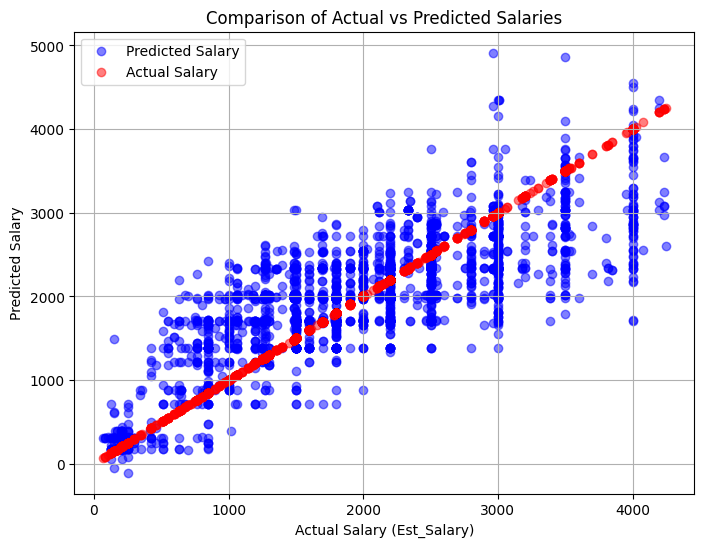

In [159]:
# Plotting the comparison between Est_Salary and Predicted_salary
plt.figure(figsize=(8, 6))
plt.scatter(new_df['Est_Salary'], new_df['predicted_salary'], color='blue', label='Predicted Salary', alpha=0.5)
plt.scatter(new_df['Est_Salary'], new_df['Est_Salary'], color='red', label='Actual Salary', alpha=0.5)
plt.xlabel('Actual Salary (Est_Salary)')
plt.ylabel('Predicted Salary')
plt.title('Comparison of Actual vs Predicted Salaries')
plt.legend()
plt.grid(True)
plt.show()

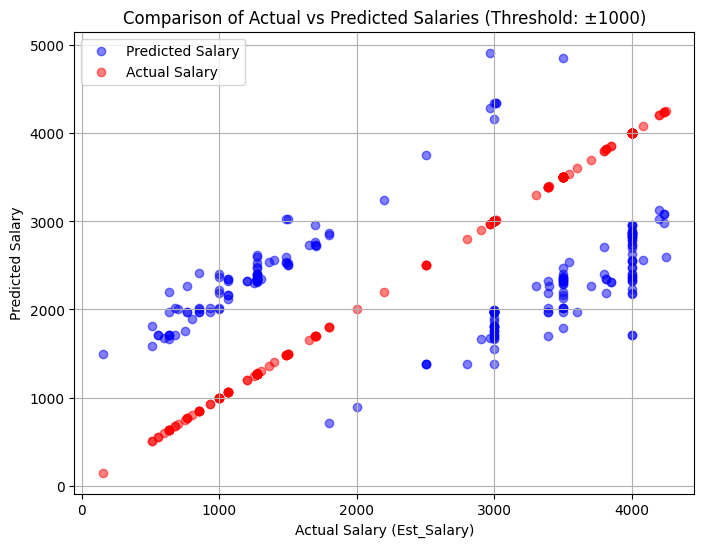

In [160]:

# Set a threshold for the difference between predicted and actual salaries
threshold = 1000  # Adjust the threshold as needed

# Filter data based on the threshold
filtered_data = new_df[abs(new_df['Est_Salary'] - new_df['predicted_salary']) > threshold]

# Plotting the comparison between Est_Salary and Predicted_salary for the filtered data
plt.figure(figsize=(8, 6))
plt.scatter(filtered_data['Est_Salary'], filtered_data['predicted_salary'], color='blue', label='Predicted Salary', alpha=0.5)
plt.scatter(filtered_data['Est_Salary'], filtered_data['Est_Salary'], color='red', label='Actual Salary', alpha=0.5)
plt.xlabel('Actual Salary (Est_Salary)')
plt.ylabel('Predicted Salary')
plt.title(f'Comparison of Actual vs Predicted Salaries (Threshold: ±{threshold})')
plt.legend()
plt.grid(True)
plt.show()


[]


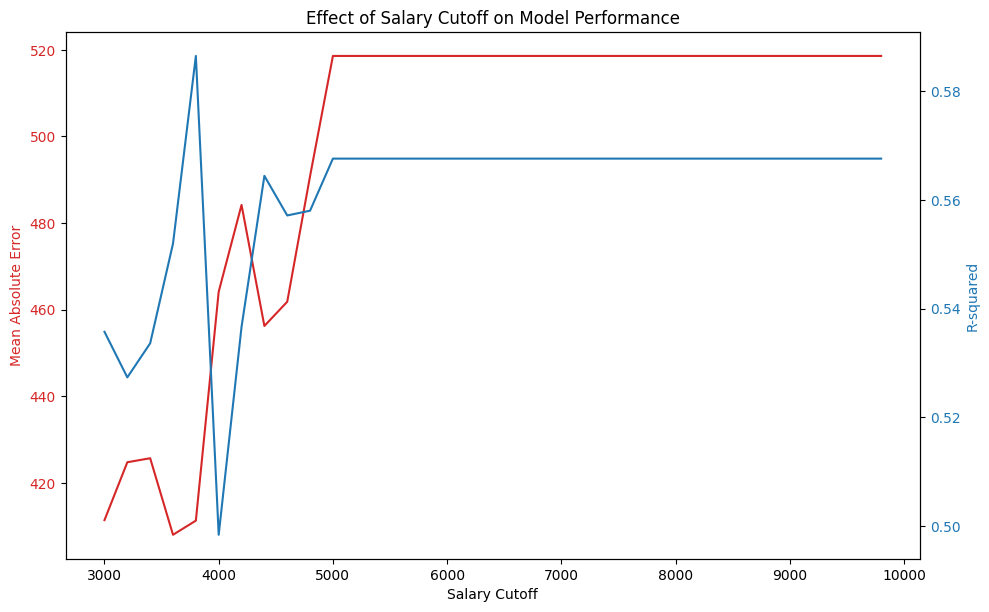

In [149]:
# Create an empty dictionary to store results
results = {'Cutoff': [], 'MAE': [], 'R2': []}
features = ['YOE', 'Min_level', 'Max_level','Remote', 'VN','Overseas','Bachelor','Master','PhD',
            'Data_Engineer', 'Data_Analyst', 'Data_Scientist', 'Business_Analyst', 'Business_Intelligence',
            'Others'
            ]
target = 'Est_Salary'

# Iterate through different cutoff values
for cutoff in range(3000, 10000, 200):  # Adjust the range and step as needed
    temp_df = new_df[new_df['Est_Salary'] <= cutoff].dropna(subset=['Est_Salary','Job_Description','YOE'])
    
    
    y = temp_df[target]
    X_train, X_test, y_train, y_test = feature_select(temp_df, features)

    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results['Cutoff'].append(cutoff)
    results['MAE'].append(mae)
    results['R2'].append(r2)

# Plot MAE and R2 against different cutoff values
# Plot MAE and R2 against different cutoff values with logarithmic scale for y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Salary Cutoff')
ax1.set_ylabel('Mean Absolute Error', color=color)
ax1.plot(results['Cutoff'], results['MAE'], color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('R-squared', color=color)
ax2.plot(results['Cutoff'], results['R2'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Effect of Salary Cutoff on Model Performance')
plt.show()

False

In this case, MAE = 647



#<a name = "Conclusion">Conclusion</a>
It's safe to conclude with further fine-tuning and model selection, we can get a better result. However, given that the low quality of the dataset, we can get to a highest 77% accuracy (2450-571/2450) prediction which is not too bad. During running some other tests I could lower MAE to 510

In [ ]:
de_df['Est_Salary'].mean()